In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MaxAbsScaler

In [3]:
df = pd.read_csv('..//data_gathering//data//team_stats.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   436 non-null    int64  
 1   Season       436 non-null    float64
 2   Team         436 non-null    object 
 3   G_bat        436 non-null    float64
 4   PA           436 non-null    float64
 5   HR           436 non-null    float64
 6   R            436 non-null    float64
 7   RBI          436 non-null    float64
 8   SB           436 non-null    float64
 9   BB%          436 non-null    float64
 10  K%           436 non-null    float64
 11  ISO          436 non-null    float64
 12  BABIP_bat    436 non-null    float64
 13  AVG          436 non-null    float64
 14  OBP          436 non-null    float64
 15  SLG          436 non-null    float64
 16  wOBA         436 non-null    float64
 17  wRC+         436 non-null    float64
 18  BsR          149 non-null    float64
 19  Off     

df here is the output of get_team_stats.py includes years from 2005 to 2019, I chose 2005 somewhat arbitrarily, but I did not want to include the height of the steroid era. 

We don't have any missing values to worry about in df, so we're moving on to look at correlations.

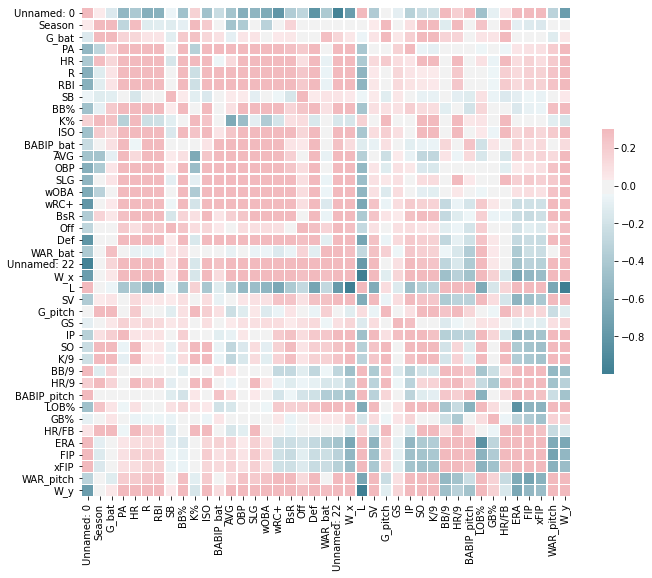

In [5]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
corr.W_y.sort_values()

L             -0.999687
Unnamed: 0    -0.752258
ERA           -0.669472
FIP           -0.545399
xFIP          -0.492863
BB/9          -0.473062
BABIP_pitch   -0.450217
HR/9          -0.330689
K%            -0.170539
HR/FB         -0.152622
G_pitch       -0.115871
Season         0.000104
SB             0.050167
G_bat          0.055923
BABIP_bat      0.118168
GS             0.150563
GB%            0.172542
Off            0.265113
WAR_bat        0.272294
K/9            0.315130
SO             0.342144
AVG            0.349496
HR             0.393187
BsR            0.399268
ISO            0.419989
PA             0.421348
BB%            0.434839
IP             0.475584
SLG            0.490438
OBP            0.524568
wOBA           0.549309
RBI            0.559794
R              0.562503
SV             0.634486
LOB%           0.647222
wRC+           0.666988
WAR_pitch      0.677104
Def            0.687062
Unnamed: 22    0.772699
W_x            1.000000
W_y            1.000000
Name: W_y, dtype

Notes:

* team wins are much more closely correlated with pitcher WAR than with batter WAR (remember that this is fangrapghs war.)
* stolen bases mean nothing (I wonder if this was still the case before SB's became much less common)
* Def -defensive runs above average- is very highly correlated to team wins! (I did not expect that)
* I wonder why batter WAR and wRC+ are so far apart. Might be a normalization thing.

Lets take out the stats that are (sortof!) contained in wOBA (AVG, OBP, SLG)
Lets also clean up some garbage (Unnamed: 0, Unnamed: 22, W_x, L)
BsR doesn't have enough values for the new expanded dataset.
losing BABIP because we know it's super noisy
Losing Games

In [6]:
df.drop(labels=['AVG',
                'OBP',
                'SLG',
                'Unnamed: 0',
                'Unnamed: 22',
                'W_x','L','Season',
                'Team',
                'BsR',
                'G_bat',
                'G_pitch',
                'GS',
                'BABIP_pitch',
                'BABIP_bat',
                'SB',
                'IP'], axis=1, inplace=True)

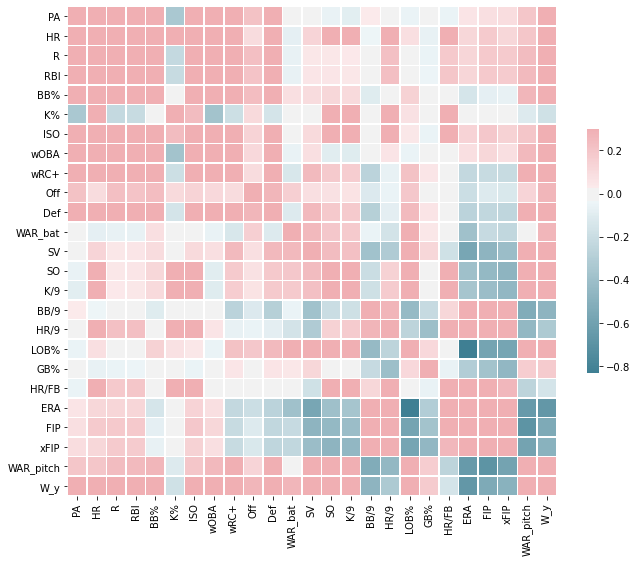

In [7]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

I am very suprised that wRC+ and WAR_hitter are so far apart. 
Let's normalize the values and see if that makes any difference.

In [8]:

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(df)

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(df)

# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)

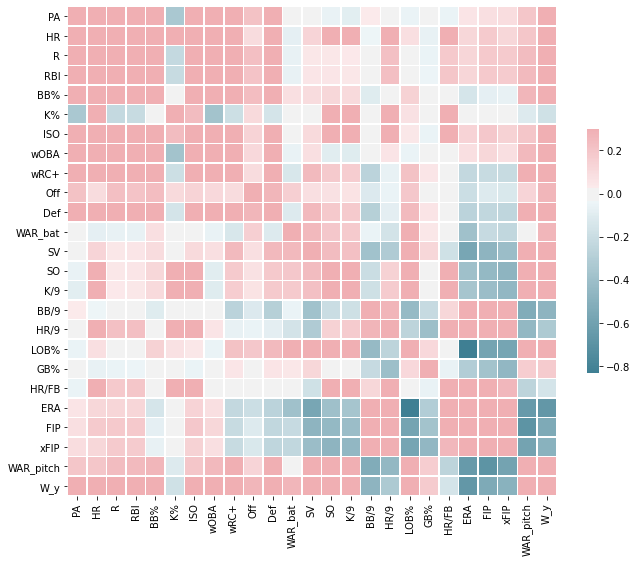

In [9]:
scaled_corr = df_scaled.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
scaled_corr.W_y.sort_values()

ERA         -0.669472
FIP         -0.545399
xFIP        -0.492863
BB/9        -0.473062
HR/9        -0.330689
K%          -0.170539
HR/FB       -0.152622
GB%          0.172542
Off          0.265113
WAR_bat      0.272294
K/9          0.315130
SO           0.342144
HR           0.393187
ISO          0.419989
PA           0.421348
BB%          0.434839
wOBA         0.549309
RBI          0.559794
R            0.562503
SV           0.634486
LOB%         0.647222
wRC+         0.666988
WAR_pitch    0.677104
Def          0.687062
W_y          1.000000
Name: W_y, dtype: float64

It makes no difference.

Let's split the batting and the pitching stats, with wins, into their own frames. Then we'll make some scatter plots.

In [11]:
df_pitch = df_scaled.loc[:,['ERA','FIP','xFIP','BB/9','HR/9','HR/FB','K/9','SO','SV','LOB%','WAR_pitch','Def','W_y']]
df_bat = df_scaled.loc[:,['wRC+','wOBA','BB%','ISO','WAR_bat','Off','GB%','K%','W_y']]

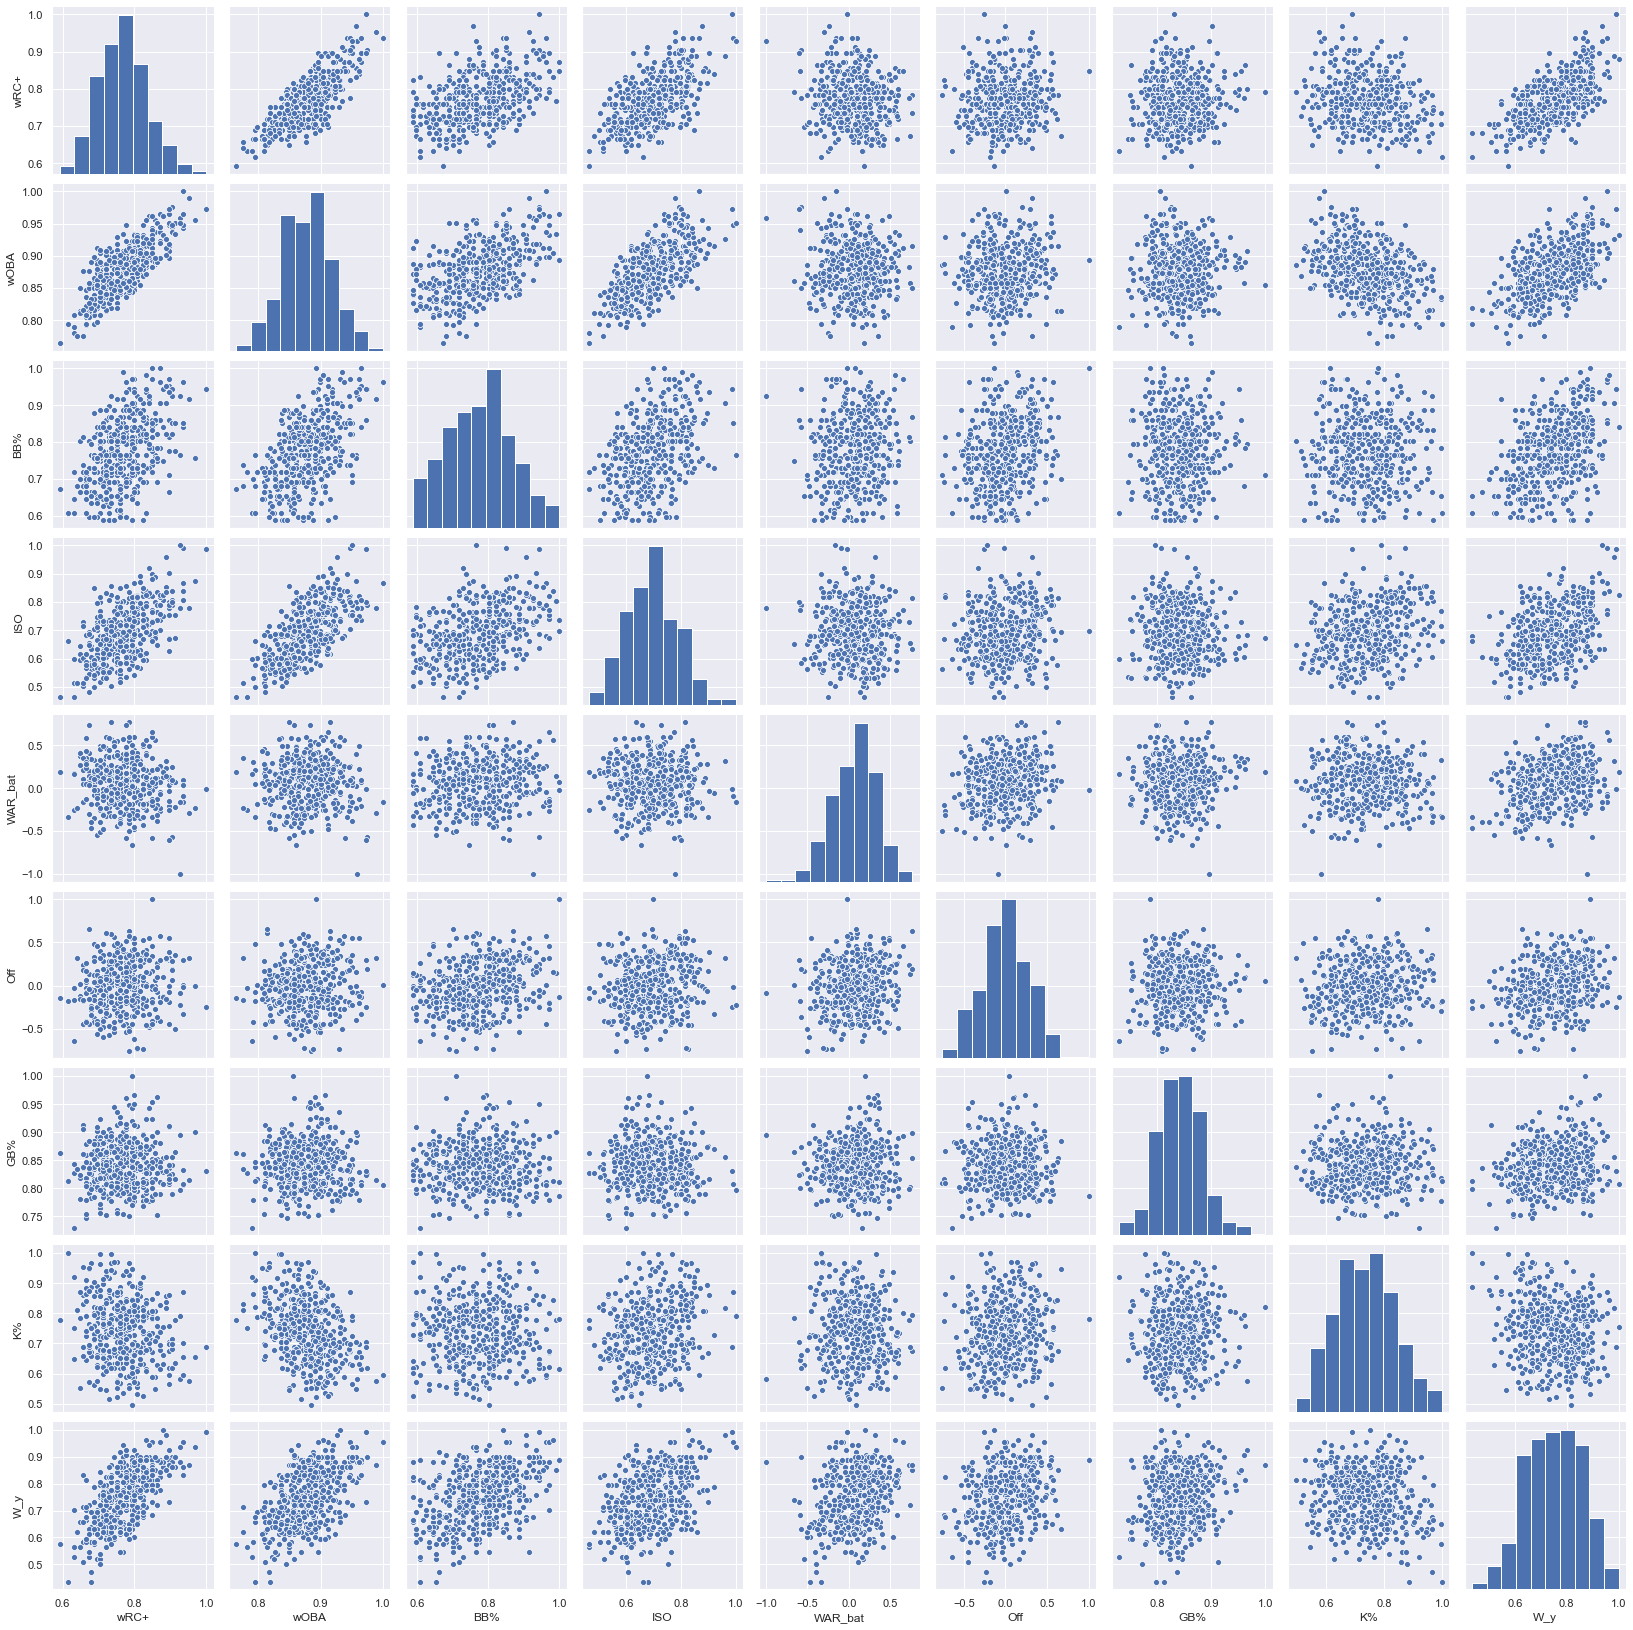

In [12]:
#scatterplot
sns.set()
sns.pairplot(df_bat, height = 2.5)
plt.show();

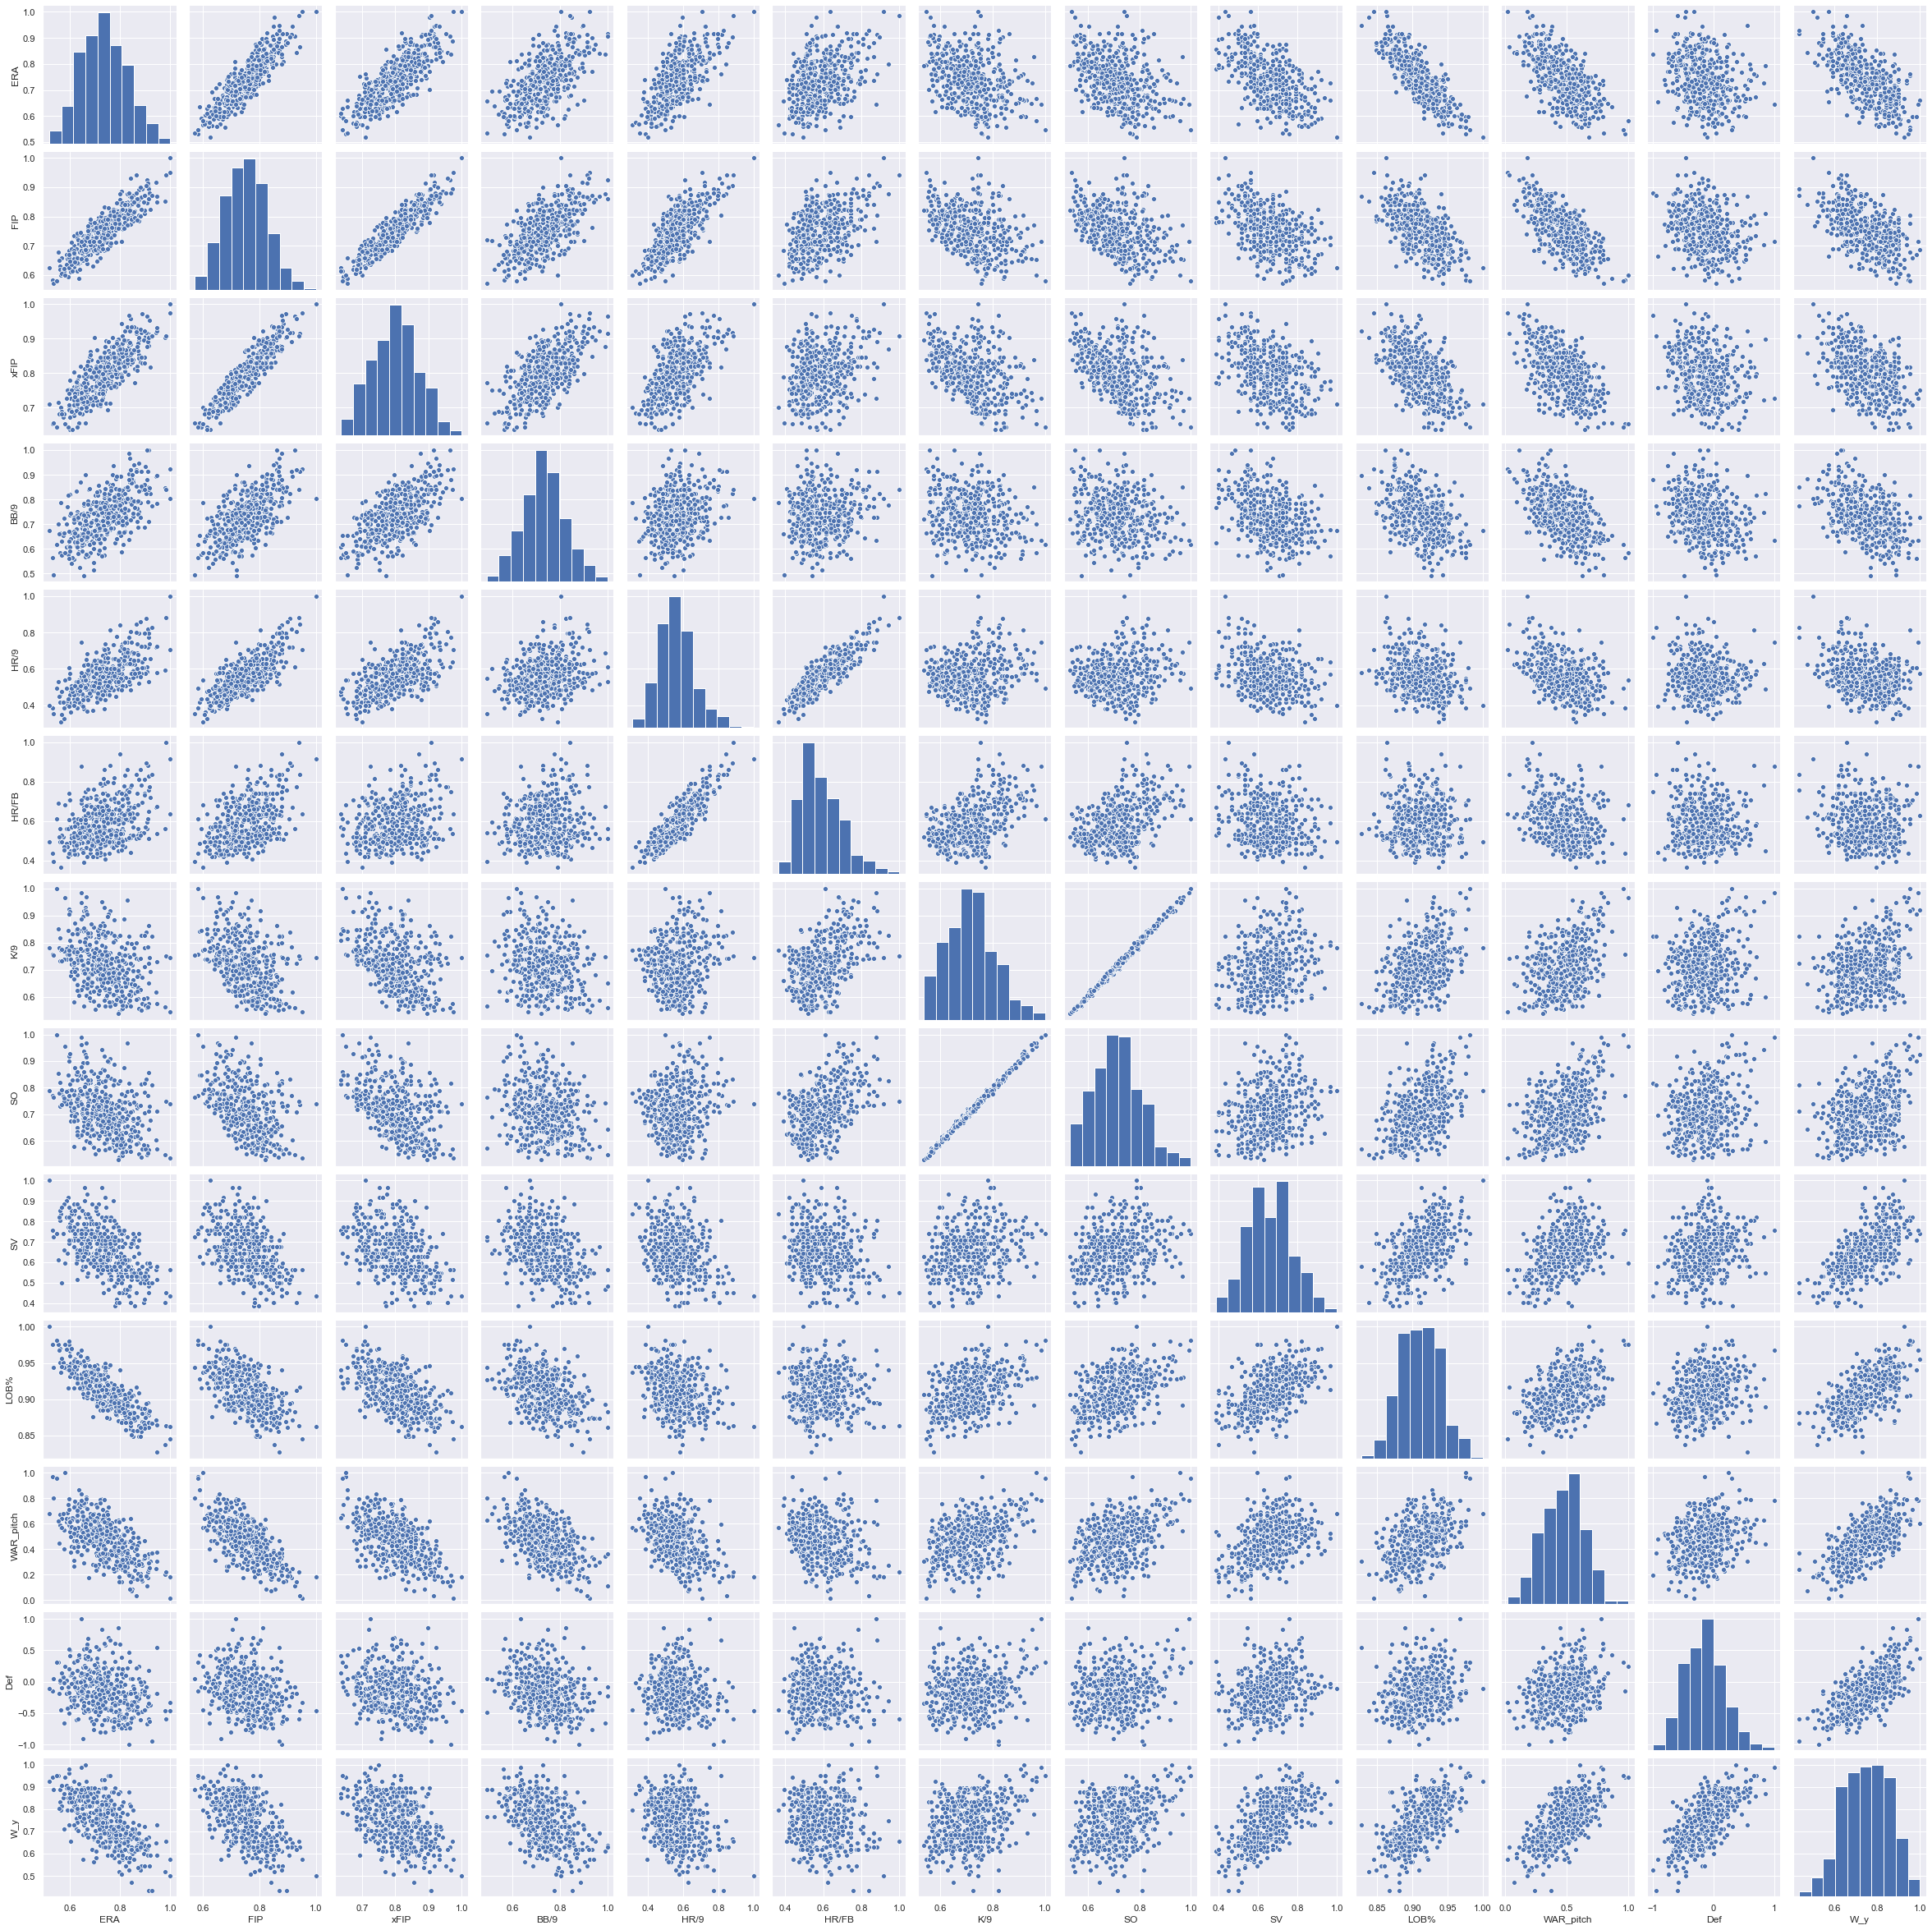

In [13]:
sns.set()
sns.pairplot(df_pitch, height = 2.5)
plt.show();

SO's and k/9 are closely correlated, which makes sense. I'll keep k/9.
hr/fb and hr/9 are also closely correlated, which again makes good sense. Only keeping hr/fb may punish a groundball pitcher who didn't give up many flyballs, so I am going to keep hr/9.
I'm picking xfip over fip

I'm thinking that instead of hanging onto all of these metrics when ERA and def are so strongly correlated with team wins, that I should pull statcast data and try to correlate things like spinrate, x/y movement, etc to ERA 

There's also a lot of room for more def numbers. (Who knew that pitching and defense were the keys to winning all along?)

In [14]:
df_pitch = df_scaled.loc[:,['ERA','xFIP','BB/9','HR/9','K/9','SV','LOB%','WAR_pitch','Def','W_y']]

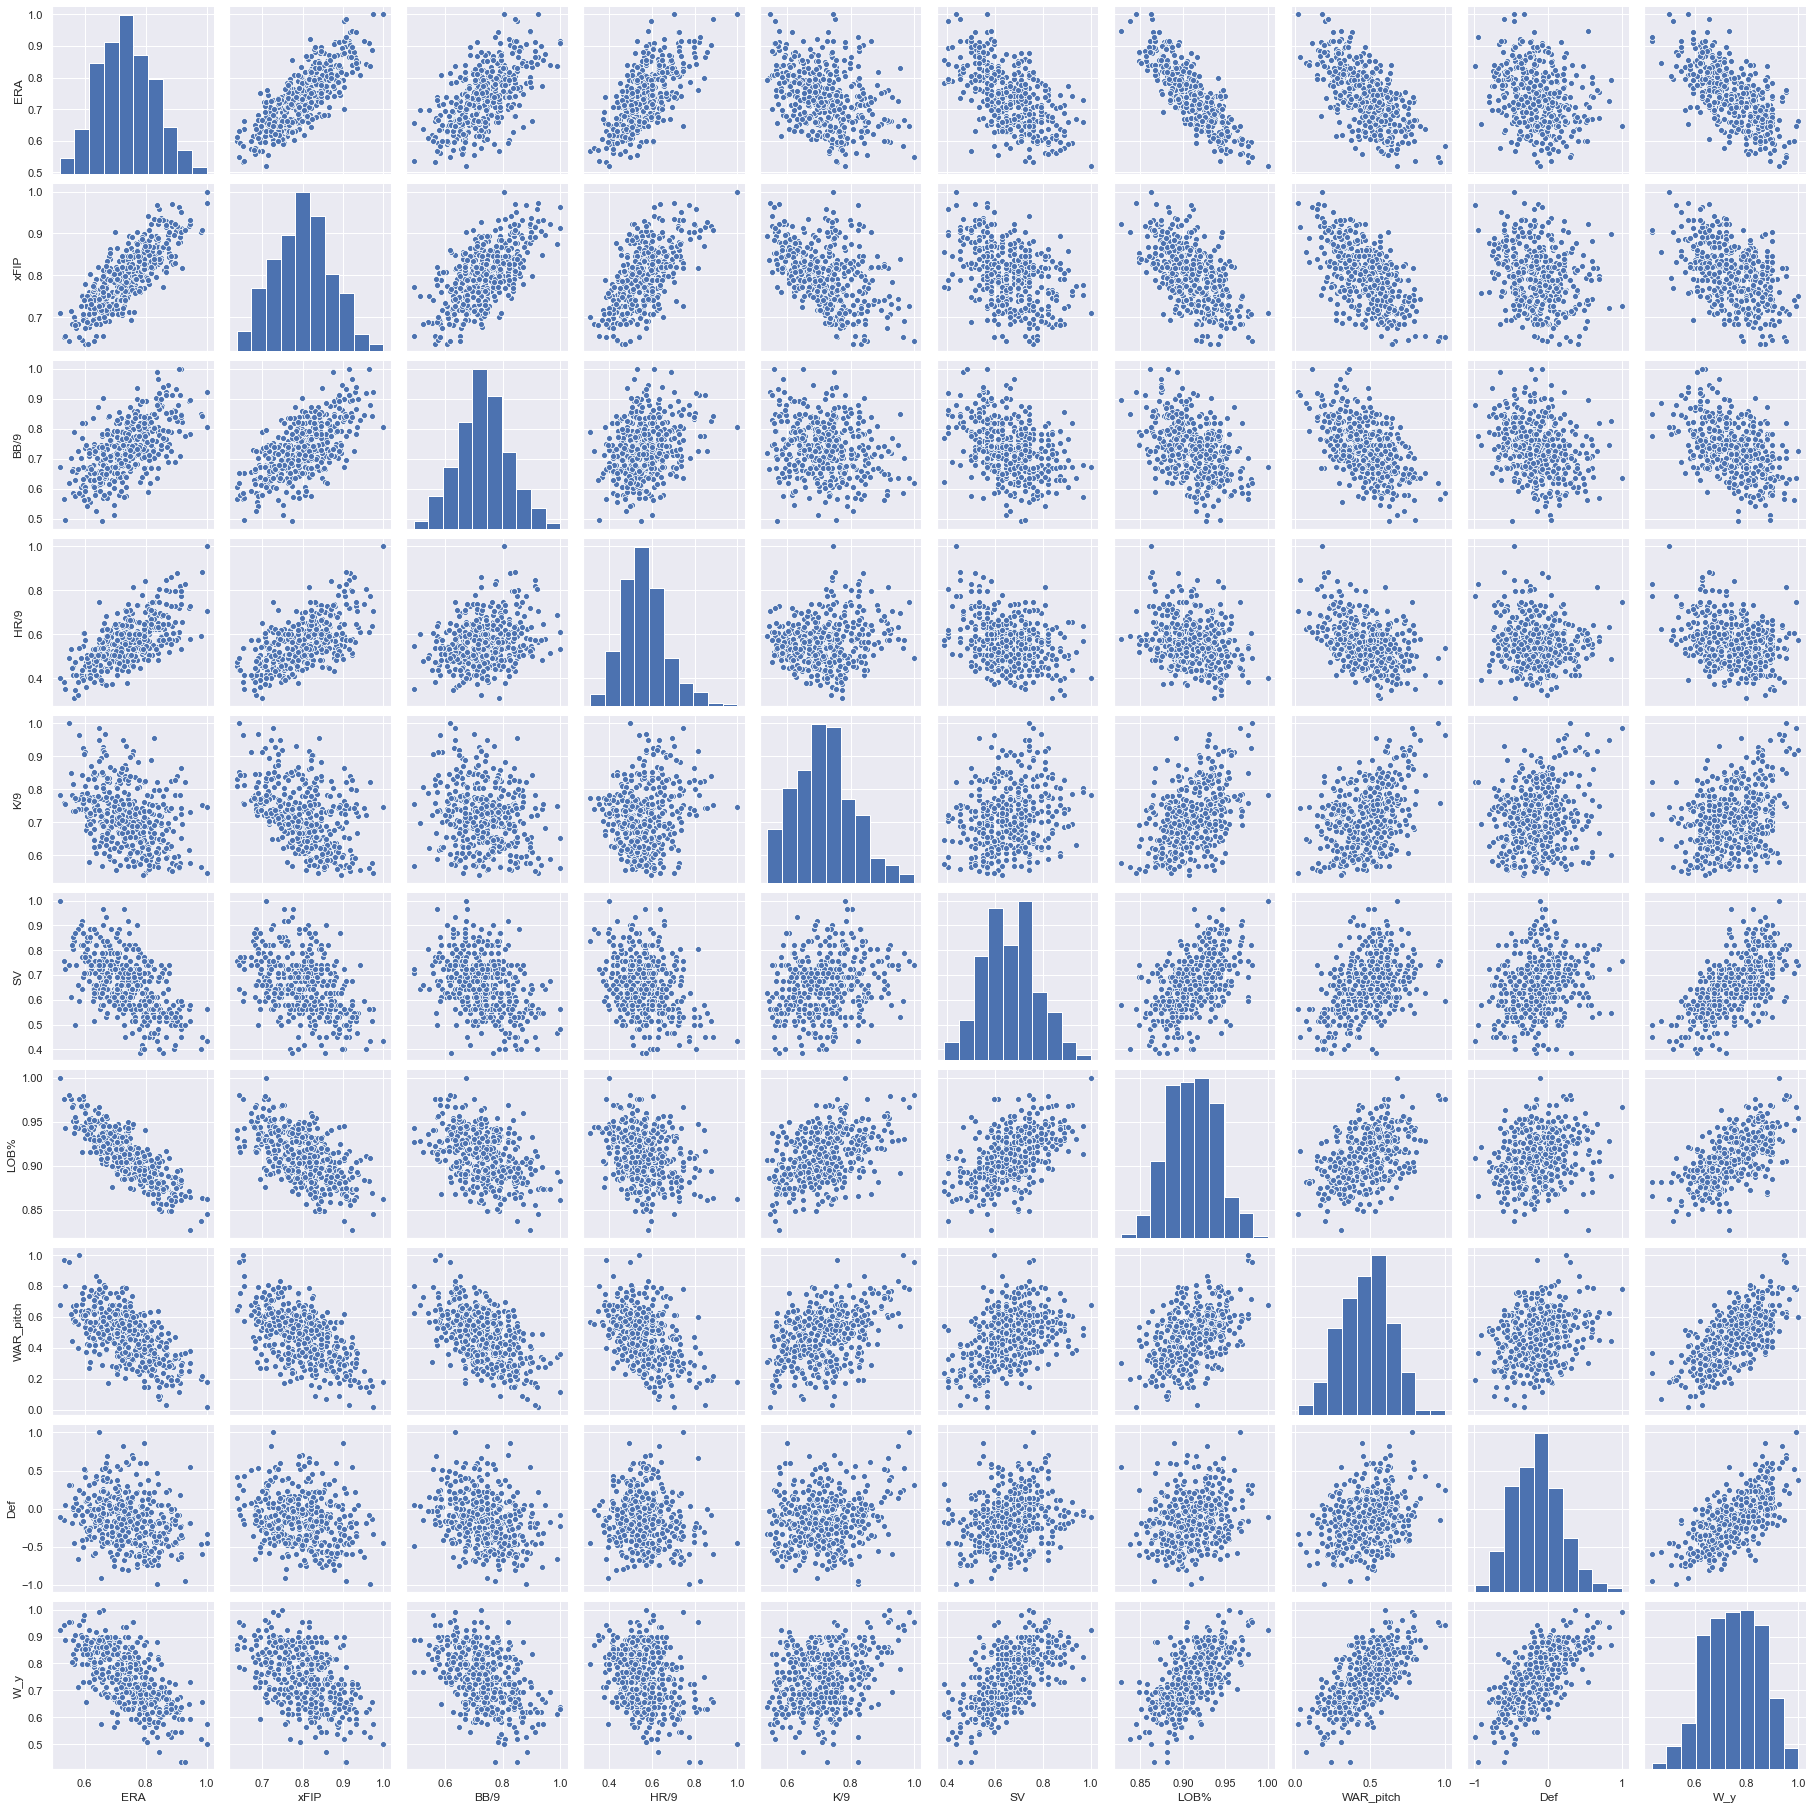

In [15]:
sns.set()
sns.pairplot(df_pitch, height = 2.5)
plt.show();

Since ERA is so closely correlated to wins, I should try to use non-results oriented data (read: fangraphs data) to see if I can predict pitcher ERA. I will then use those features in the final algorithm to predict wins.